In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math

# Loading and tidying up the data

First of all, we need to have a look at the data we are working with. In this case I decided to use as a source the Data Spreassheet for Animal Crossing New Horizons, which can be found [here](https://tinyurl.com/acnh-sheet). A very comprehensive list of items, clothing, etc. including the list of [Villagers](https://docs.google.com/spreadsheets/d/13d_LAJPlxMa_DubPTuirkIV4DERBMXbrWQsmSh8ReK4/edit#gid=161944347)!

So let's load it up and have a look at it!


In [2]:
villagers = pd.read_csv('Data Spreadsheet for Animal Crossing New Horizons - Villagers.csv')

In [3]:
villagers.head()

,Name,Icon Image,Photo Image,House Image,Species,Gender,Personality,Subtype,Hobby,Birthday,...,Color 2,Default Clothing,Wallpaper,Flooring,Furniture List,Furniture Name List,Name Color,Bubble Color,Filename,Unique Entry ID
0,Admiral,NaN,NaN,NaN,Bird,Male,Cranky,A,Nature,1/27,...,Blue,3164,dirt-clod wall,tatami,717;1849;7047;2736;787;5970;3449;3622;3802;410...,clay furnace;kotatsu;zen cushion;retro fan;tap...,#fffce9,#0ca54a,brd06,B3RyfNEqwGmcccRC3
1,Agent S,NaN,NaN,NaN,Squirrel,Female,Peppy,B,Fitness,7/2,...,Black,12036,concrete wall,colorful tile flooring,7845;7150;3468;4080;290;3971;3449;1708;4756;25...,pull-up-bar stand;blue corner;beach towel;long...,#fffce9,#0961f6,squ05,SGMdki6dzpDZyXAw5
2,Agnes,NaN,NaN,NaN,Pig,Female,Big Sister,A,Play,4/21,...,White,4290,gray molded-panel wall,arabesque flooring,4129;7236;7235;7802;896;3428;4027;7325;3958;71...,monstera;lily record player;rose bed;pet bed;c...,#fffce9,#515151,pig17,jzWCiDPm9MqtCfecP
3,Al,NaN,NaN,NaN,Gorilla,Male,Lazy,B,Fitness,10/18,...,White,3244,concrete wall,green rubber flooring,1452;4078;4013;833;4116;3697;7845;3307;3946;39...,weight bench;barbell;punching bag;upright lock...,#fffad4,#798040,gor08,LBifxETQJGEaLhBjC
4,Alfonso,NaN,NaN,NaN,Alligator,Male,Lazy,B,Play,6/9,...,Blue,7969,yellow playroom wall,green honeycomb tile,4763;3205;3701;1557;3623;85;3208;3584;4761;121...,throwback dino screen;wooden-block stereo;writ...,#fffce9,#e8b010,crd00,REpd8KxB8p9aGBRSE


## Dropping columns we don't need

As we can see above, there's a lot of information that might not be of use like the list of furniture/decoration the villager originally has or the blank columns that in the Google Sheet held the villager icons and images. So we'll et a list of all columns in the dataframe and drop the ones we won't need.

In [4]:
villagers.columns

Index(['Name', 'Icon Image', 'Photo Image', 'House Image', 'Species', 'Gender',
       'Personality', 'Subtype', 'Hobby', 'Birthday', 'Catchphrase',
       'Favorite Song', 'Favorite Saying', 'Style 1', 'Style 2', 'Color 1',
       'Color 2', 'Default Clothing', 'Wallpaper', 'Flooring',
       'Furniture List', 'Furniture Name List', 'Name Color', 'Bubble Color',
       'Filename', 'Unique Entry ID'],
      dtype='object')

In [5]:
villagers.drop(columns= ['Icon Image', 'Photo Image', 'House Image', 'Subtype', 'Catchphrase', 'Favorite Saying', 'Style 1', 'Style 2', 'Color 1', 'Color 2', 'Default Clothing', 'Wallpaper', 'Flooring', 'Furniture List', 'Furniture Name List', 'Name Color', 'Bubble Color', 'Unique Entry ID'], inplace= True)


## Birthday to date

As we can see in the preview above as well, the birthdays are in the MM/DD format, stored as strings. So we'll transform them into `datetime` type, placing them in the current year (2020).

In [6]:
villagers['Birthday'] = pd.to_datetime(villagers['Birthday'], format = "%m/%d")
villagers['Birthday'] = villagers['Birthday'].apply(lambda dt: dt.replace(year = 2020))

## Changing  Gender and Personality to vectorable values
As the total 8 personality types in the game for villagers are actually split into 4 for each gender, I've decided to refactor the female and male counterparts into the same value. I thought it made more sense to do it this way and "degender" the personality, as we already have a Gender value that we can apply to get the exact Personality.

In [7]:
villagers["Gender"] = villagers["Gender"].replace(["Female", "Male"], [0, 1])

I decided it'd be an interesting idea to arrange the personality types in a 'spiciness' scale, based on how often these villagers can say something "out of line". Therefore, we have the Normal and Lazy villagers as 'mild' with a value of 0 and Snooty and Cranky villagers with a 'very hot' rating of 3.


| Spiciness/ *Gender*	| Mild - 0 	| Medium - 1   	| Hot - 2    	| Very Hot - 3 	|
|----------------------	|----------	|--------------	|--------------	|--------------	|
| *Female* - 0        	| Normal   	| Peppy      	| Big Sister 	| Snooty       	|
| *Male* - 1          	| Lazy     	| Jock       	| Smug       	| Cranky       	|

In [8]:
villagers["Personality"] = villagers["Personality"].replace(["Normal", "Lazy"], 0)
villagers["Personality"] = villagers["Personality"].replace(["Peppy", "Jock"], 1)
villagers["Personality"] = villagers["Personality"].replace(["Big Sister", "Smug"], 2)
villagers["Personality"] = villagers["Personality"].replace(["Snooty", "Cranky"], 3)

In [9]:
villagers.head()

,Name,Species,Gender,Personality,Hobby,Birthday,Favorite Song,Filename
0,Admiral,Bird,1,3,Nature,2020-01-27,Steep Hill,brd06
1,Agent S,Squirrel,0,1,Fitness,2020-07-02,Go K.K. Rider,squ05
2,Agnes,Pig,0,2,Play,2020-04-21,K.K. House,pig17
3,Al,Gorilla,1,0,Fitness,2020-10-18,Go K.K. Rider,gor08
4,Alfonso,Alligator,1,0,Play,2020-06-09,Forest Life,crd00


## Changing the Species to numerical values
By default in the games, the 'Cow' and 'Bull' Species are gender exclusive mutually. So the first thing we need to do before anything else is to unify these two into the same Species which I have decided to call 'Cattle'.

In [10]:
villagers["Species"] = villagers["Species"].replace(["Cow", "Bull"], "Cattle")

Once that's done, we need to have a look at how many species of villagers we have in the Animal Crossing universe.

In [11]:
species = sorted(villagers.Species.unique())
print(species)
len(species)

['Alligator', 'Anteater', 'Bear', 'Bird', 'Cat', 'Cattle', 'Chicken', 'Cub', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Frog', 'Goat', 'Gorilla', 'Hamster', 'Hippo', 'Horse', 'Kangaroo', 'Koala', 'Lion', 'Monkey', 'Mouse', 'Octopus', 'Ostrich', 'Penguin', 'Pig', 'Rabbit', 'Rhino', 'Sheep', 'Squirrel', 'Tiger', 'Wolf']


34

It turns that based on our data, that's a total of 34!
Now in order to replace the species with numerical values we just have to create a dictionary with the species as the key and assign a numerical value to each.

In [12]:
species_dict = dict(zip(species, range(len(species))))
print(species_dict)

{'Alligator': 0, 'Anteater': 1, 'Bear': 2, 'Bird': 3, 'Cat': 4, 'Cattle': 5, 'Chicken': 6, 'Cub': 7, 'Deer': 8, 'Dog': 9, 'Duck': 10, 'Eagle': 11, 'Elephant': 12, 'Frog': 13, 'Goat': 14, 'Gorilla': 15, 'Hamster': 16, 'Hippo': 17, 'Horse': 18, 'Kangaroo': 19, 'Koala': 20, 'Lion': 21, 'Monkey': 22, 'Mouse': 23, 'Octopus': 24, 'Ostrich': 25, 'Penguin': 26, 'Pig': 27, 'Rabbit': 28, 'Rhino': 29, 'Sheep': 30, 'Squirrel': 31, 'Tiger': 32, 'Wolf': 33}


However, after I thought this through I realised this made no sense. If I was ranking the Personality on a 'spiciness' scale, why was I just assigning values to the Species arbitrarily (alphabetically)?

I thought it'd make sense if we organised them in a 'phylogenetic tree' kind of way, similar to how New Horizons shows the different villager species in the last room at the Fossil area in the museum. I did a bit of searching online and found this wonderful [Animal Crossing Cladogram](https://www.reddit.com/r/AnimalCrossing/comments/ffwkvb/i_made_a_cladogram_for_all_the_species_of_the/) by [SaxoLaxo](https://www.reddit.com/user/SaxoLaxo/) on Reddit. 



![cladogram](img/Cladogram.jpg)


However, for the sake of brevity I'll be simplifying this classification a little bit:

- We'll be using the in-game Species, instead of its irl ones: Queenie (emu), Flora (flamingo), Cranston (crane) and Julia (peacock) will stay as 'Ostrich'.


| Queenie                   	| Flora                   	| Cranston                   	| Julia                   	|
|:---------------------------:	|:------------------------: |:---------------------------:  |:------------------------:	|
| ![Queenie](img/ost00.png) 	| ![Flora](img/ost09.png) 	| ![Cranston](img/ost06.png) 	| ![Julia](img/ost05.png) 	|
| *An Ostrich*                       	| *Another Ostrich*               	| *Yet another Ostrich*                      	| *And another one*                	|


- Distance between species has been simplified: If going down a branch there's no species in the left sub-branch, the current sub-brach will be ignored and not accounted for.





In [13]:
species_dict.update({'Octopus': 0, 'Frog': 1, 'Alligator': 2, 'Ostrich': 3, 'Chicken': 4, 'Duck': 5, 'Penguin': 6, 'Eagle': 7, 'Bird': 8, 'Kangaroo': 9, 'Koala': 10, 'Anteater': 11, 'Elephant': 12, 'Gorilla': 13, 'Monkey': 14, 'Rabbit': 15, 'Squirrel': 16, 'Mouse': 17, 'Hamster': 18, 'Pig': 19, 'Hippo': 20, 'Deer': 21, 'Cattle': 22, 'Goat': 23, 'Sheep': 24, 'Horse': 25, 'Rhino': 26, 'Tiger': 27, 'Lion': 28, 'Cat': 29, 'Dog': 30, 'Wolf': 31, 'Cub': 32, 'Bear': 33 })

Again, I came to the conclusion that this solution wasn't any good either. While it made more sense than having them alphabetically, it was still quite arbitrary to have the jump of just 1 unit between certain species. It should be obvious that the space between Lion to Cat, and Octopus to Frog is not the same. So it shouldn't be represented this way. Also, not a good reasoning either behing having Bird followed by Kangaroo and not Bird to Koala, for example. I decided this idea was not good enough and dropped altogether.

So I grabbed squared paper and decided to represent the cladogram in a 3D space, taking a slight (and probably not-very-well informed) phylogenetic tree approach. Basically, the Y axis would represent the order of the Species, and where the X and Z axes would be "medium" or "environment" habitates. This way it'd be easier for me to spread them around the 3D space, which I decided would be a 10x10x10 cube. Z and X would take values from -5 to 5 and Y would go from 0 to 9 as seen below.


| Y value 	| Order      	|
|---------	|------------	|
| Y = 0   	| Bilateria  	|
| Y = 1   	| Vertebrata 	|
| Y = 2    	| Sarcopterygh 	|
| Y = 3    	| Reptilia     	|
| Y = 4    	| Dinosauria   	|
| Y = 5    	| Struthioniformes                          	|
| Y = 6    	| Galloanserae, Marsupiala and Atlantogenata	|
| Y = 7   	| Passerea, Primates and untamed Glires     	|


At this point I noticed the rest of the species could be divided by animals that have been tamed by the humankind or big/small species in the same order. So I assigned the last two levels as:

| Y value 	| Order      	|
|---------	|------------	|
| Y = 8    	|  Wild Fereuungulata 	|
| Y = 9    	| Tamed Fereuungulata and tamed Glires 	|
 


In regards to X and Z, the plane would be divided in 3 sections.
- Terrestrial creatures will be allocated the space where X =< 0.
- Aquatic cretures would then take the space where X => 0 and Z => 0.
- Lastly, flying creatures will be located in the X => 0 and Z =< 0 space.

The graph below should help visualise this.

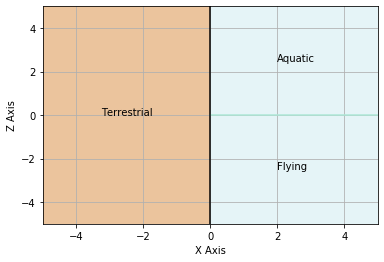

In [14]:
x =[]
y = []
fig, ax = plt.subplots()

ax.plot(x, y)
ax.grid()
ax.margins(0) 
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("X Axis")
plt.ylabel("Z Axis")
ax.text(-3.25, 0, "Terrestrial")
ax.text(2, 2.5, "Aquatic")
ax.text(2, -2.5, "Flying")

ax.axhline(y=0, xmin=.5, color='#ace8d6')
ax.axvline(x=0, color='black')
ax.axvspan(-5, 0, facecolor='#d98b3d', alpha=0.5)
ax.axvspan(0, 5, facecolor='#cceaf0', alpha=0.5)


plt.show()

In [15]:
spatial_species = {'Octopus': {"x": 3, "z": 3, "y": 0}, 'Frog': {"x": 0, "z": 2, "y": 2}, 'Alligator': {"x": -1, "z": 1, "y": 3}, 'Ostrich': {"x": -2, "z": 0, "y": 5}, 'Chicken': {"x": -2, "z": -1, "y": 6}, 'Duck': {"x": -1, "z": 0, "y": 6}, 'Kangaroo': {"x": -4, "z": 5, "y": 6}, 'Koala': {"x": -3, "z": 5, "y": 6}, 'Anteater': {"x": -4, "z": 3, "y": 6}, 'Elephant': {"x": -1, "z": 3, "y": 6}, 'Penguin': {"x": 1, "z": 1, "y": 7}, 'Eagle': {"x": 1, "z": -1, "y": 7}, 'Bird': {"x": 0, "z": -2, "y": 7},  'Gorilla': {"x": -3, "z": 2, "y": 7}, 'Monkey': {"x": -3, "z": 3, "y": 7}, 'Rabbit': {"x": -4, "z": 5, "y": 7}, 'Squirrel': {"x": -5, "z": 4, "y": 7}, 'Mouse': {"x": -5, "z": 5, "y": 7}, 'Hippo': {"x": 0, "z": 3, "y": 8}, 'Deer': {"x": -2, "z": 0, "y": 8}, 'Rhino': {"x": -1, "z": 2, "y": 8}, 'Tiger': {"x": -5, "z": 3, "y": 8}, 'Lion': {"x": -5, "z": 2, "y": 8}, 'Bear': {"x": -5, "z": -1, "y": 8}, 'Wolf': {"x": -5, "z": -5, "y": 8}, 'Cattle': {"x": -3, "z": 0, "y": 9}, 'Goat': {"x": -3, "z": 1, "y": 9}, 'Sheep': {"x": -2, "z": 1, "y": 9}, 'Horse': {"x": -2, "z": -2, "y": 9}, 'Cat': {"x": -5, "z": 2, "y": 9}, 'Hamster': {"x": -5, "z": 5, "y": 9}, 'Pig': {"x": -1, "z": 2, "y": 9}, 'Dog': {"x": -5, "z": -5, "y": 9}, 'Cub': {"x": -5, "z": -1, "y": 9}}

In [16]:
coordenates = {}
for species, location in spatial_species.items():
    new_values = np.array(list(location.values()))
    coordenates.update({species: new_values})
print(coordenates)
print(type(coordenates))
print(type(new_values))

{'Octopus': array([3, 3, 0]), 'Frog': array([0, 2, 2]), 'Alligator': array([-1,  1,  3]), 'Ostrich': array([-2,  0,  5]), 'Chicken': array([-2, -1,  6]), 'Duck': array([-1,  0,  6]), 'Kangaroo': array([-4,  5,  6]), 'Koala': array([-3,  5,  6]), 'Anteater': array([-4,  3,  6]), 'Elephant': array([-1,  3,  6]), 'Penguin': array([1, 1, 7]), 'Eagle': array([ 1, -1,  7]), 'Bird': array([ 0, -2,  7]), 'Gorilla': array([-3,  2,  7]), 'Monkey': array([-3,  3,  7]), 'Rabbit': array([-4,  5,  7]), 'Squirrel': array([-5,  4,  7]), 'Mouse': array([-5,  5,  7]), 'Hippo': array([0, 3, 8]), 'Deer': array([-2,  0,  8]), 'Rhino': array([-1,  2,  8]), 'Tiger': array([-5,  3,  8]), 'Lion': array([-5,  2,  8]), 'Bear': array([-5, -1,  8]), 'Wolf': array([-5, -5,  8]), 'Cattle': array([-3,  0,  9]), 'Goat': array([-3,  1,  9]), 'Sheep': array([-2,  1,  9]), 'Horse': array([-2, -2,  9]), 'Cat': array([-5,  2,  9]), 'Hamster': array([-5,  5,  9]), 'Pig': array([-1,  2,  9]), 'Dog': array([-5, -5,  9]), 'Cub

In [17]:
# As a series
coord_series = pd.Series(coordenates)
print(coord_series)

Octopus        [3, 3, 0]
Frog           [0, 2, 2]
Alligator     [-1, 1, 3]
Ostrich       [-2, 0, 5]
Chicken      [-2, -1, 6]
Duck          [-1, 0, 6]
Kangaroo      [-4, 5, 6]
Koala         [-3, 5, 6]
Anteater      [-4, 3, 6]
Elephant      [-1, 3, 6]
Penguin        [1, 1, 7]
Eagle         [1, -1, 7]
Bird          [0, -2, 7]
Gorilla       [-3, 2, 7]
Monkey        [-3, 3, 7]
Rabbit        [-4, 5, 7]
Squirrel      [-5, 4, 7]
Mouse         [-5, 5, 7]
Hippo          [0, 3, 8]
Deer          [-2, 0, 8]
Rhino         [-1, 2, 8]
Tiger         [-5, 3, 8]
Lion          [-5, 2, 8]
Bear         [-5, -1, 8]
Wolf         [-5, -5, 8]
Cattle        [-3, 0, 9]
Goat          [-3, 1, 9]
Sheep         [-2, 1, 9]
Horse        [-2, -2, 9]
Cat           [-5, 2, 9]
Hamster       [-5, 5, 9]
Pig           [-1, 2, 9]
Dog          [-5, -5, 9]
Cub          [-5, -1, 9]
dtype: object


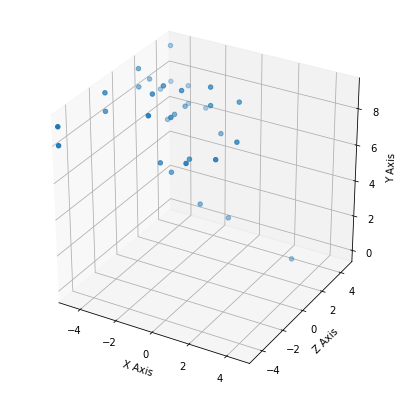

In [18]:
data = coord_series.values

xs, zs, ys = zip(*data)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter(xs, zs, ys)

ax.set_xlabel('X Axis')
ax.set_ylabel('Z Axis')
ax.set_zlabel('Y Axis')

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

plt.show()

In [19]:
coord_df = pd.DataFrame({"Species": coord_series.index, "SpeciesXZY": coord_series.values})

In [20]:
villagers = pd.DataFrame.merge(villagers, coord_df, how = "left", left_on = ["Species"], right_on = ["Species"])

In [21]:
species_df_icons = pd.DataFrame({"Species": villagers.Species, "Icon_Path": villagers.Filename.str.slice(0,3)})
species_df_icons

,Species,Icon_Path
0,Bird,brd
1,Squirrel,squ
2,Pig,pig
3,Gorilla,gor
4,Alligator,crd
...,...,...
386,Horse,hrs
387,Wolf,wol
388,Koala,kal
389,Deer,der


In [22]:
species_df_icons["Icon_Path"].replace("bul", "cow", inplace = True)
path_list = "img/" + species_df_icons["Icon_Path"].unique() + "_icon.png"
print(path_list)
species_list = species_df_icons["Species"].unique()
print(species_list)
path_df = pd.DataFrame({"Species": species_list, "Path": path_list})
path_df.head()

['img/brd_icon.png' 'img/squ_icon.png' 'img/pig_icon.png'
 'img/gor_icon.png' 'img/crd_icon.png' 'img/kal_icon.png'
 'img/pbr_icon.png' 'img/ant_icon.png' 'img/cow_icon.png'
 'img/mus_icon.png' 'img/cat_icon.png' 'img/hrs_icon.png'
 'img/ham_icon.png' 'img/kgr_icon.png' 'img/wol_icon.png'
 'img/pgn_icon.png' 'img/chn_icon.png' 'img/elp_icon.png'
 'img/shp_icon.png' 'img/der_icon.png' 'img/tig_icon.png'
 'img/cbr_icon.png' 'img/dog_icon.png' 'img/bea_icon.png'
 'img/hip_icon.png' 'img/duk_icon.png' 'img/goa_icon.png'
 'img/ost_icon.png' 'img/rbt_icon.png' 'img/lon_icon.png'
 'img/flg_icon.png' 'img/mnk_icon.png' 'img/rhn_icon.png'
 'img/ocp_icon.png']
['Bird' 'Squirrel' 'Pig' 'Gorilla' 'Alligator' 'Koala' 'Eagle' 'Anteater'
 'Cattle' 'Mouse' 'Cat' 'Horse' 'Hamster' 'Kangaroo' 'Wolf' 'Penguin'
 'Chicken' 'Elephant' 'Sheep' 'Deer' 'Tiger' 'Cub' 'Dog' 'Bear' 'Hippo'
 'Duck' 'Goat' 'Ostrich' 'Rabbit' 'Lion' 'Frog' 'Monkey' 'Rhino' 'Octopus']


,Species,Path
0,Bird,img/brd_icon.png
1,Squirrel,img/squ_icon.png
2,Pig,img/pig_icon.png
3,Gorilla,img/gor_icon.png
4,Alligator,img/crd_icon.png


In [23]:
coord_df  = pd.DataFrame.merge(coord_df, path_df, how = "left", left_on = ["Species"], right_on = ["Species"])
coord_df.head()

,Species,SpeciesXZY,Path
0,Octopus,"[3, 3, 0]",img/ocp_icon.png
1,Frog,"[0, 2, 2]",img/flg_icon.png
2,Alligator,"[-1, 1, 3]",img/crd_icon.png
3,Ostrich,"[-2, 0, 5]",img/ost_icon.png
4,Chicken,"[-2, -1, 6]",img/chn_icon.png


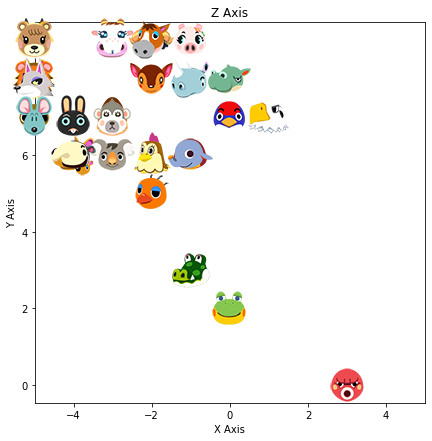

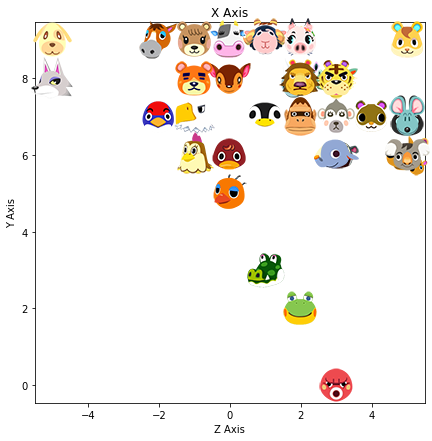

In [24]:
def getImage(path):
    return OffsetImage(plt.imread(path))

paths = coord_df["Path"]

x, z, y = zip(*coord_df["SpeciesXZY"])

fig, ax = plt.subplots(figsize= (7,7))
ax.scatter(x, y)
plt.title('Z Axis')
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.xlim(-5, 5)

for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.show()

fig, ax = plt.subplots(figsize= (7,7))
ax.scatter(z, y)
plt.title('X Axis')
plt.xlabel("Z Axis")
plt.ylabel("Y Axis")

for z0, y0, path in zip(z, y, paths):
    ab = AnnotationBbox(getImage(path), (z0, y0), frameon=False)
    ax.add_artist(ab)
plt.show()

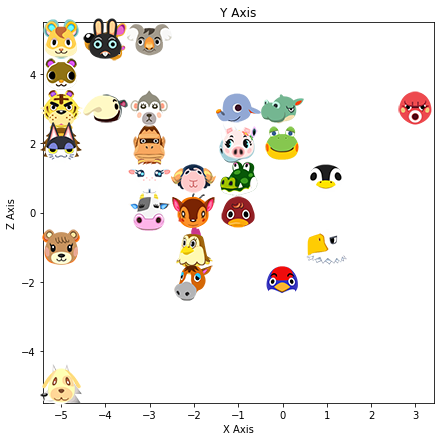

In [25]:
paths = coord_df["Path"]

x, z, y = zip(*coord_df["SpeciesXZY"])

fig, ax = plt.subplots(figsize= (7,7))
ax.scatter(x, z)
plt.title('Y Axis')
plt.xlabel("X Axis")
plt.ylabel("Z Axis")

for x0, z0, path in zip(x, z, paths):
    ab = AnnotationBbox(getImage(path), (x0, z0), frameon=False)
    ax.add_artist(ab)
plt.show()

In [26]:
coord_df["X"], coord_df["Z"], coord_df["Y"] = zip(*coord_df["SpeciesXZY"])
coord_df.head()

,Species,SpeciesXZY,Path,X,Z,Y
0,Octopus,"[3, 3, 0]",img/ocp_icon.png,3,3,0
1,Frog,"[0, 2, 2]",img/flg_icon.png,0,2,2
2,Alligator,"[-1, 1, 3]",img/crd_icon.png,-1,1,3
3,Ostrich,"[-2, 0, 5]",img/ost_icon.png,-2,0,5
4,Chicken,"[-2, -1, 6]",img/chn_icon.png,-2,-1,6


In [27]:
def scatter_plot(species_frame):
    paths = species_frame["Path"]

    x, z, y = zip(*species_frame["SpeciesXZY"])

    fig, ax = plt.subplots(figsize= (7,7))
    ax.scatter(x, z)
    plt.title(f"Y = {level}")
    plt.xlabel("X Axis")
    plt.ylabel("Z Axis")
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    ax.axhline(y=0, xmin=.5, color='#ace8d6')
    ax.axvline(x=0, color='black')
    ax.axvspan(-5, 0, facecolor='#d98b3d', alpha=0.5)
    ax.axvspan(0, 5, facecolor='#cceaf0', alpha=0.5)

    for x0, z0, path in zip(x, z, paths):
        ab = AnnotationBbox(getImage(path), (x0, z0), frameon=False)
        ax.add_artist(ab)
    plt.show()

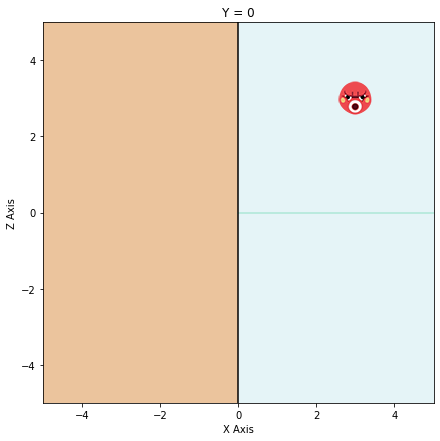

,Species,SpeciesXZY,Path,X,Z,Y
0,Octopus,"[3, 3, 0]",img/ocp_icon.png,3,3,0


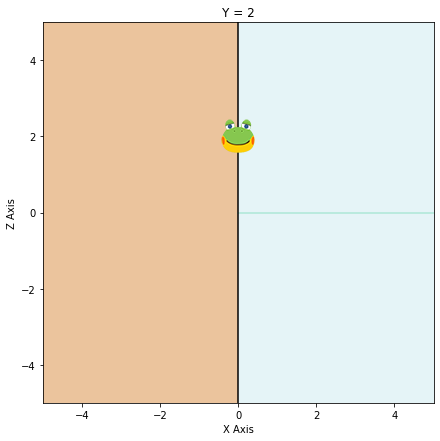

,Species,SpeciesXZY,Path,X,Z,Y
1,Frog,"[0, 2, 2]",img/flg_icon.png,0,2,2


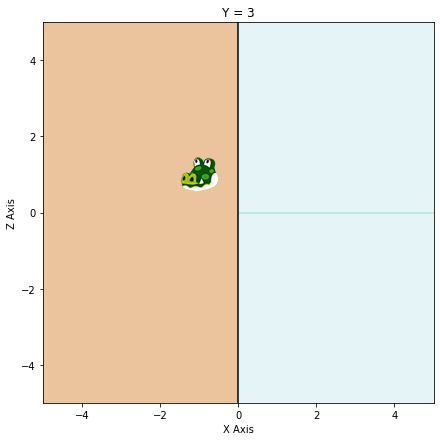

,Species,SpeciesXZY,Path,X,Z,Y
2,Alligator,"[-1, 1, 3]",img/crd_icon.png,-1,1,3


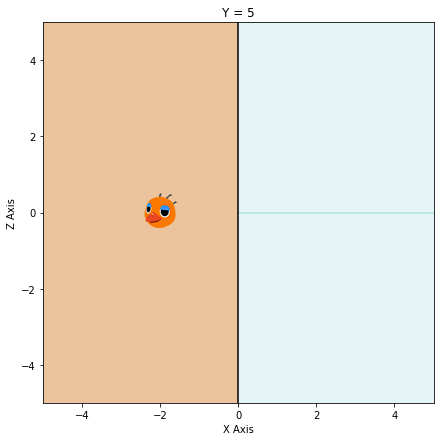

,Species,SpeciesXZY,Path,X,Z,Y
3,Ostrich,"[-2, 0, 5]",img/ost_icon.png,-2,0,5


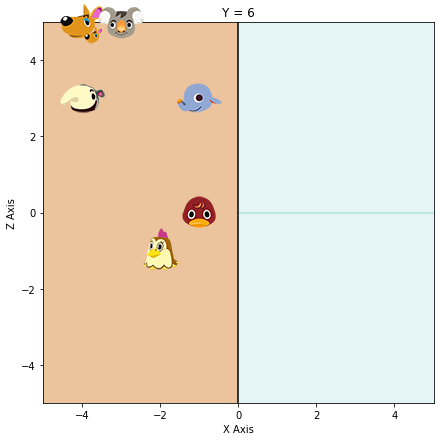

,Species,SpeciesXZY,Path,X,Z,Y
4,Chicken,"[-2, -1, 6]",img/chn_icon.png,-2,-1,6
5,Duck,"[-1, 0, 6]",img/duk_icon.png,-1,0,6
6,Kangaroo,"[-4, 5, 6]",img/kgr_icon.png,-4,5,6
7,Koala,"[-3, 5, 6]",img/kal_icon.png,-3,5,6
8,Anteater,"[-4, 3, 6]",img/ant_icon.png,-4,3,6
9,Elephant,"[-1, 3, 6]",img/elp_icon.png,-1,3,6


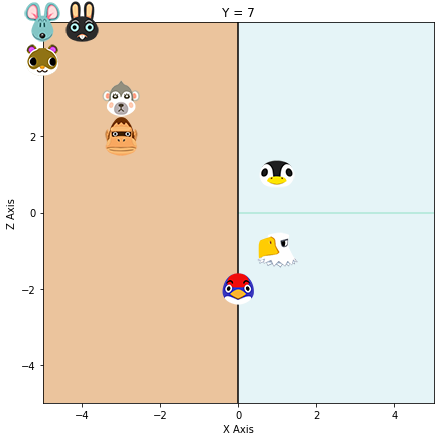

,Species,SpeciesXZY,Path,X,Z,Y
10,Penguin,"[1, 1, 7]",img/pgn_icon.png,1,1,7
11,Eagle,"[1, -1, 7]",img/pbr_icon.png,1,-1,7
12,Bird,"[0, -2, 7]",img/brd_icon.png,0,-2,7
13,Gorilla,"[-3, 2, 7]",img/gor_icon.png,-3,2,7
14,Monkey,"[-3, 3, 7]",img/mnk_icon.png,-3,3,7
15,Rabbit,"[-4, 5, 7]",img/rbt_icon.png,-4,5,7
16,Squirrel,"[-5, 4, 7]",img/squ_icon.png,-5,4,7
17,Mouse,"[-5, 5, 7]",img/mus_icon.png,-5,5,7


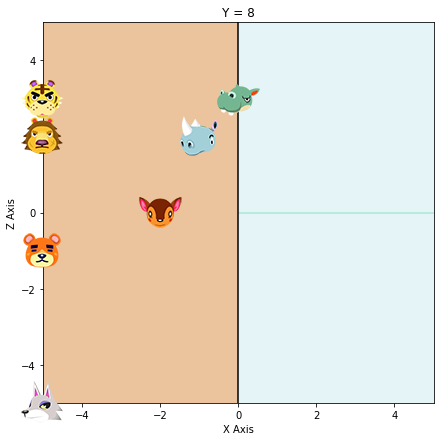

,Species,SpeciesXZY,Path,X,Z,Y
18,Hippo,"[0, 3, 8]",img/hip_icon.png,0,3,8
19,Deer,"[-2, 0, 8]",img/der_icon.png,-2,0,8
20,Rhino,"[-1, 2, 8]",img/rhn_icon.png,-1,2,8
21,Tiger,"[-5, 3, 8]",img/tig_icon.png,-5,3,8
22,Lion,"[-5, 2, 8]",img/lon_icon.png,-5,2,8
23,Bear,"[-5, -1, 8]",img/bea_icon.png,-5,-1,8
24,Wolf,"[-5, -5, 8]",img/wol_icon.png,-5,-5,8


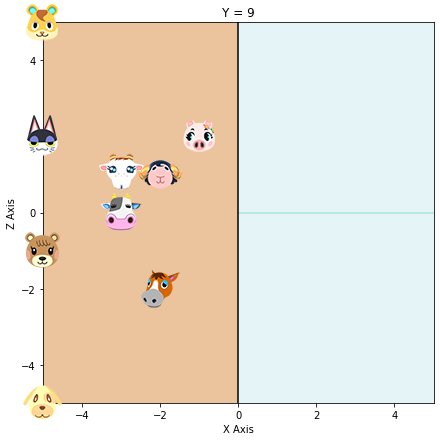

,Species,SpeciesXZY,Path,X,Z,Y
25,Cattle,"[-3, 0, 9]",img/cow_icon.png,-3,0,9
26,Goat,"[-3, 1, 9]",img/goa_icon.png,-3,1,9
27,Sheep,"[-2, 1, 9]",img/shp_icon.png,-2,1,9
28,Horse,"[-2, -2, 9]",img/hrs_icon.png,-2,-2,9
29,Cat,"[-5, 2, 9]",img/cat_icon.png,-5,2,9
30,Hamster,"[-5, 5, 9]",img/ham_icon.png,-5,5,9
31,Pig,"[-1, 2, 9]",img/pig_icon.png,-1,2,9
32,Dog,"[-5, -5, 9]",img/dog_icon.png,-5,-5,9
33,Cub,"[-5, -1, 9]",img/cbr_icon.png,-5,-1,9


In [28]:
for level in range(0,10):
    if not coord_df[coord_df.Y == level].empty:
        scatter_plot(coord_df[coord_df.Y == level])
        display(coord_df[coord_df.Y == level])

In [29]:
def distance(coord1, coord2):
    #  Allison Parrish recommended to not use this - as apparently it's very slow(?)
    # Replace eventually
    return math.sqrt(sum([(i - j)**2 for i, j in zip(coord1, coord2)]))

In [30]:
# Use this fuction to calculate the closeness of one species to another (as it'll always discard itself)
# To calculate the closeness of a species to any point use closest_inc() - below
def closest (coord, space = coordenates, n=2):
    closest = []
    for key in sorted(space.keys(),
                        key=lambda x: distance(coord, space[x]))[:n]:
        closest.append(key)
    return closest[1]

In [31]:
for species in coordenates:
    print(f"The closest species to {species} is: " + closest(coordenates[species]))

The closest species to Octopus is: Frog
The closest species to Frog is: Alligator
The closest species to Alligator is: Frog
The closest species to Ostrich is: Chicken
The closest species to Chicken is: Ostrich
The closest species to Duck is: Ostrich
The closest species to Kangaroo is: Koala
The closest species to Koala is: Kangaroo
The closest species to Anteater is: Monkey
The closest species to Elephant is: Monkey
The closest species to Penguin is: Eagle
The closest species to Eagle is: Bird
The closest species to Bird is: Eagle
The closest species to Gorilla is: Monkey
The closest species to Monkey is: Gorilla
The closest species to Rabbit is: Kangaroo
The closest species to Squirrel is: Mouse
The closest species to Mouse is: Rabbit
The closest species to Hippo is: Rhino
The closest species to Deer is: Cattle
The closest species to Rhino is: Pig
The closest species to Tiger is: Lion
The closest species to Lion is: Tiger
The closest species to Bear is: Cub
The closest species to Wolf

In [32]:
# Creating sliders
x_slider = widgets.IntSlider(description='x:', value=3, min=-5, max=5)
z_slider = widgets.IntSlider(description='z:', value=0, min=-5, max=5, orientation='vertical')
y_slider = widgets.IntSlider(description='y:', value=0, min=0, max=9, orientation='vertical')

#Creating the widget that places the sliders together
ui_xz = widgets.VBox([z_slider, x_slider])
ui = widgets.HBox([ui_xz, y_slider])

# Functions that run to 

def closest_inc (coord, space = coordenates, n=1):
    closest = []
    for key in sorted(space.keys(),
                        key=lambda x: distance(coord, space[x]))[:n]:
        closest.append(key)
    return closest[0]

def resulting_sliders(a, b, c):
    print("The closest species to", (a, b, c))

def resulting_species(x, z, y):
    print("is " + closest_inc([x, z, y]))

def returning_path(x, z, y):
    print(coord_df.Path[coord_df.Species == closest_inc([x, z, y])].item())

def create_image(x, z, y):
    icon_path = (coord_df.Path[coord_df.Species == closest_inc([x, z, y])].item())
    return display(widgets.Image(value= open(icon_path, "rb").read(), format='png', width=45, height=45))

# Objects that connect the sliders to the functions
sliders_out = widgets.interactive_output(resulting_sliders, {'a': x_slider, 'b': z_slider, 'c': y_slider})
result = widgets.interactive_output(resulting_species, {'x': x_slider, 'z': z_slider, 'y': y_slider})
sliders_icon = widgets.interactive_output(returning_path, {'x': x_slider, 'z': z_slider, 'y': y_slider})
portrait = widgets.interactive_output(create_image, {'x': x_slider, 'z': z_slider, 'y': y_slider})

sentence = widgets.HBox([sliders_out, result])
full_result= widgets.VBox([sentence, portrait])
interactive_out = widgets.HBox([ui, full_result])
display(interactive_out)

In [33]:
villagers[villagers.Species == "Cat"].sort_values(by="Hobby")

,Name,Species,Gender,Personality,Hobby,Birthday,Favorite Song,Filename,SpeciesXZY
364,Tom,Cat,1,3,Education,2020-12-10,K.K. Rock,cat15,"[-5, 2, 9]"
198,Kiki,Cat,0,0,Education,2020-10-08,Only Me,cat04,"[-5, 2, 9]"
238,Mitzi,Cat,0,0,Education,2020-09-25,K.K. Love Song,cat01,"[-5, 2, 9]"
134,Felicity,Cat,0,1,Fashion,2020-03-30,K.K. Stroll,cat17,"[-5, 2, 9]"
241,Monique,Cat,0,3,Fashion,2020-09-30,K.K. Cruisin',cat11,"[-5, 2, 9]"
200,Kitty,Cat,0,3,Fashion,2020-02-15,K.K. Chorale,cat14,"[-5, 2, 9]"
293,Purrl,Cat,0,3,Fashion,2020-05-29,K.K. Chorale,cat07,"[-5, 2, 9]"
233,Merry,Cat,0,1,Fashion,2020-06-29,Neapolitan,cat16,"[-5, 2, 9]"
344,Stinky,Cat,1,1,Fitness,2020-08-17,K.K. Flamenco,cat13,"[-5, 2, 9]"
196,Kid Cat,Cat,1,1,Fitness,2020-08-01,Go K.K. Rider,cat10,"[-5, 2, 9]"


In [34]:
hobbies = sorted(villagers.Hobby.unique())
print(hobbies)

['Education', 'Fashion', 'Fitness', 'Music', 'Nature', 'Play']


widgets.Combobox(
    value='John',
    placeholder='Choose Someone',
    options=['Paul', 'John', 'George', 'Ringo'],
    description='Combobox:',
    ensure_option=True,
    disabled=False
)